In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages', '/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing/notebooks']); import pickle; snakemake = pickle.loads(b'\x80\x04\x95\xea \x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8cYresults/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx\x94\x8c[results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv\x94\x8cdresults/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes_filtered.tsv\x94\x8c[results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv\x94\x8c_results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\x06matrix\x94K\x00N\x86\x94\x8c\rcell_barcodes\x94K\x01N\x86\x94\x8c\x16cell_barcodes_filtered\x94K\x02N\x86\x94\x8c\x08features\x94K\x03N\x86\x94\x8c\x10cell_annotations\x94K\x04N\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh\x1e\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h$)}\x94\x8c\x05_name\x94h\x1esNt\x94bh\x1fh"h$\x85\x94R\x94(h$)}\x94h(h\x1fsNt\x94bh\x12h\nh\x14h\x0bh\x16h\x0ch\x18h\rh\x1ah\x0eub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8cLresults/viral_fastq10x/scProgenyProduction_trial3_viral_genes_by_cell.csv.gz\x94\x8cIresults/viral_fastq10x/scProgenyProduction_trial3_viral_genes_by_cell.svg\x94e}\x94(h\x10}\x94(\x8c\x17viral_genes_by_cell_csv\x94K\x00N\x86\x94\x8c\x04plot\x94K\x01N\x86\x94uh\x1c]\x94(h\x1eh\x1feh\x1eh"h$\x85\x94R\x94(h$)}\x94h(h\x1esNt\x94bh\x1fh"h$\x85\x94R\x94(h$)}\x94h(h\x1fsNt\x94bh6h2h8h3ub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(]\x94(\x8c\x06fluPB2\x94\x8c\x06fluPB1\x94\x8c\x05fluPA\x94\x8c\x05fluHA\x94\x8c\x05fluNP\x94\x8c\x05fluNA\x94\x8c\x04fluM\x94\x8c\x05fluNS\x94e]\x94(\x8c\x05fluHA\x94\x8c\x05fluNA\x94ee}\x94(h\x10}\x94(\x8c\x0bviral_genes\x94K\x00N\x86\x94\x8c\x14barcoded_viral_genes\x94K\x01N\x86\x94uh\x1c]\x94(h\x1eh\x1feh\x1eh"h$\x85\x94R\x94(h$)}\x94h(h\x1esNt\x94bh\x1fh"h$\x85\x94R\x94(h$)}\x94h(h\x1fsNt\x94bhUhGhWhPub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94\x8c\x1ascProgenyProduction_trial3\x94a}\x94(h\x10}\x94\x8c\x04expt\x94K\x00N\x86\x94sh\x1c]\x94(h\x1eh\x1feh\x1eh"h$\x85\x94R\x94(h$)}\x94h(h\x1esNt\x94bh\x1fh"h$\x85\x94R\x94(h$)}\x94h(h\x1fsNt\x94b\x8c\x04expt\x94hfub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01e}\x94(h\x10}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94uh\x1c]\x94(h\x1eh\x1feh\x1eh"h$\x85\x94R\x94(h$)}\x94h(h\x1esNt\x94bh\x1fh"h$\x85\x94R\x94(h$)}\x94h(h\x1fsNt\x94bh|K\x01h~K\x01ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8cAresults/logs/viral_gene_presence_scProgenyProduction_trial3.ipynb\x94a}\x94(h\x10}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh\x1c]\x94(h\x1eh\x1feh\x1eh"h$\x85\x94R\x94(h$)}\x94h(h\x1esNt\x94bh\x1fh"h$\x85\x94R\x94(h$)}\x94h(h\x1fsNt\x94bh\x90h\x8dub\x8c\x06config\x94}\x94(\x8c\x08max_cpus\x94K\x10\x8c\x07log_dir\x94\x8c\x0cresults/logs\x94\x8c\x0cfastq10x_dir\x94\x8c\x10results/fastq10x\x94\x8c\npacbio_dir\x94\x8c\x0eresults/pacbio\x94\x8c\x0emkfastq10x_dir\x94\x8c\x1fresults/fastq10x/mkfastq_output\x94\x8c\ngenome_dir\x94\x8c\x0fresults/genomes\x94\x8c\trefgenome\x94\x8c\x19results/genomes/refgenome\x94\x8c\x14aligned_fastq10x_dir\x94\x8c\x18results/aligned_fastq10x\x94\x8c\x12viral_fastq10x_dir\x94\x8c\x16results/viral_fastq10x\x94\x8c\x1bviral_tags_bcs_in_cells_dir\x94\x8c\x1fresults/viral_tags_bcs_in_cells\x94\x8c\x11viral_progeny_dir\x94\x8c\x15results/viral_progeny\x94\x8c\x13align_and_parse_dir\x94\x8c#results/pacbio/CA09_align_and_parse\x94\x8c\x0fcell_genome_ftp\x94\x8cmftp://ftp.ensembl.org/pub/release-98/fasta/canis_familiaris/dna/Canis_familiaris.CanFam3.1.dna.toplevel.fa.gz\x94\x8c\x0ccell_gtf_ftp\x94\x8c^ftp://ftp.ensembl.org/pub/release-98/gtf/canis_familiaris/Canis_familiaris.CanFam3.1.98.gtf.gz\x94\x8c\x0cviral_genome\x94\x8c!data/flu_sequences/flu-CA09.fasta\x94\x8c\tviral_gtf\x94\x8c\x1fdata/flu_sequences/flu-CA09.gtf\x94\x8c\rviral_genbank\x94\x8c\x1edata/flu_sequences/flu-CA09.gb\x94\x8c\x14viral_tag_identities\x94\x8c+data/flu_sequences/flu-CA09_viral_tags.yaml\x94\x8c\x0fviral_amplicons\x94\x8c.data/flu_sequences/pacbio_amplicons/fluCA09.gb\x94\x8c\x11amplicon_features\x94\x8c9data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml\x94\x8c\x1eamplicon_linearization_primers\x94\x8c=data/flu_sequences/pacbio_amplicons/linearization_primers.tsv\x94\x8c\x15amplicon_to_reference\x94\x8c=data/flu_sequences/pacbio_amplicons/amplicon_to_reference.csv\x94\x8c\x0escoreGapNoncan\x94J\xfc\xff\xff\xff\x8c\x0cscoreGapGCAG\x94J\xfc\xff\xff\xff\x8c\x0cscoreGapATAC\x94J\xfc\xff\xff\xff\x8c\x14cb_whitelist_10x_url\x94\x8cvhttps://raw.githubusercontent.com/10XGenomics/cellranger/master/lib/python/cellranger/barcodes/3M-february-2018.txt.gz\x94\x8c\x10cb_whitelist_10x\x94\x8c-results/aligned_fastq10x/cb_whitelist_10x.txt\x94\x8c\ncb_len_10x\x94K\x10\x8c\x0bumi_len_10x\x94K\x0c\x8c\x14total_UMI_deviations\x94G@\x04\x00\x00\x00\x00\x00\x00\x8c\x13infection_threshold\x94G?\x84z\xe1G\xae\x14{\x8c\rviral_tag_fdr\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x1dviral_barcode_upstream_length\x94K\x1c\x8c\x16viral_barcode_mismatch\x94K\x00\x8c\x12viral_barcode_minq\x94K\x1e\x8c\x17progeny_detection_limit\x94\x8c\x041e-5\x94\x8c\x0cviral_bc_fdr\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x0eccs_min_length\x94K2\x8c\x0eccs_max_length\x94M\x88\x13\x8c\nccs_min_rq\x94G?\xef\xf7\xce\xd9\x16\x87+\x8c\x0bexperiments\x94}\x94\x8c\x1ascProgenyProduction_trial3\x94}\x94(\x8c\x0bdescription\x94X\x1b\x01\x00\x00Single-cell transcriptomics performed on even lower MOI-infected sample. Innoculum volumes based on `scProgenyProduction_trial1` and `scProgenyProduction_trial2` data. Loaded all collected cells from two 24-well wells, each infected with either wildtype or dblySn viral tag variants.\x94\x8c\tlab_notes\x94\x8c0https://benchling.com/s/etr-N4laiIAy3AUePJdig7wR\x94\x8c\rexpect_ncells\x94M\x10\'\x8c\x0ftranscriptomics\x94}\x94(\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe5\x03\x0c\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8c_/shared/ngs/illumina/bloom_lab/210312_D00300_1192_BHKHNYBCX3/raw/210312_D00300_1192_BHKHNYBCX3/\x94\x8c\x04lane\x94K\x01\x8c\x10index_sequencing\x94\x8c\x06single\x94uh\xeaC\x04\x07\xe5\x04\t\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8c_/shared/ngs/illumina/bloom_lab/210409_D00300_1210_BHKC7KBCX3/raw/210409_D00300_1210_BHKC7KBCX3/\x94\x8c\x04lane\x94\x8c\x01*\x94\x8c\x10index_sequencing\x94\x8c\x06single\x94uh\xeaC\x04\x07\xe5\x08\x19\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8c_/shared/ngs/illumina/bloom_lab/210825_D00300_1310_BHMH5TBCX3/raw/210825_D00300_1310_BHMH5TBCX3/\x94\x8c\x04lane\x94h\xff\x8c\x10index_sequencing\x94\x8c\x04none\x94uh\xeaC\x04\x07\xe5\t\x0f\x94\x85\x94R\x94}\x94(\x8c\x05index\x94\x8c\x08SI-TT-A3\x94\x8c\nbcl_folder\x94\x8cY/shared/ngs/illumina/bloom_lab/210915_VH00699_2_AAAMCL7M5/raw/210915_VH00699_2_AAAMCL7M5/\x94\x8c\x04lane\x94h\xff\x8c\x10index_sequencing\x94\x8c\x04none\x94uu\x8c\x17pacbio_viral_sequencing\x94}\x94(\x8c\x1c2021-08-05_all_segments_run1\x94\x8cp/fh/fast/bloom_j/SR/ngs/pacbio/210730_SequelIIe/r64272e_20210730_182729/1_A01/m64272e_210730_193026.subreads.bam\x94\x8c\x1c2021-09-17_all_segments_run2\x94\x8cp/fh/fast/bloom_j/SR/ngs/pacbio/210917_SequelIIe/r64272e_20210917_174421/1_A01/m64272e_210917_175514.subreads.bam\x94u\x8c\x0eviral_barcodes\x94}\x94(\x8c\x0bsupernatant\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/WT-sup-fluHA-rep1_S9_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/WT-sup-fluHA-rep2_S13_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/WT-sup-fluNA-rep1_S1_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x86/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-sup-fluNA-rep2_S1_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluHA-rep1_S10_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluHA-rep2_S14_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x94/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluNA-rep1_S2_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x04\x08\x94\x85\x94R\x94\x8c\x94/shared/ngs/illumina/bloom_lab/210408_M04866_0464_000000000-JL5M4_new-demux/Data/Intensities/BaseCalls/dblSyn-sup-fluNA-rep2_S6_L001_R1_001.fastq.gz\x94suuu\x8c\x10second_infection\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x85/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluHA-rep1_S2_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x85/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluHA-rep2_S3_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x86/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluNA-rep1_S11_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x86/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/WT-SI-fluNA-rep2_S12_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x89/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluHA-rep1_S4_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x89/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluHA-rep2_S5_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x8a/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluNA-rep1_S13_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xeaC\x04\x07\xe5\x05\x11\x94\x85\x94R\x94\x8c\x8a/shared/ngs/illumina/bloom_lab/210517_M03100_0681_000000000-JL4TM/Data/Intensities/BaseCalls/dblSyn-SI-fluNA-rep2_S14_L001_R1_001.fastq.gz\x94suuuuusu\x8c\x04rule\x94\x8c\x13viral_gene_presence\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c[/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing/notebooks\x94ub.'); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir('/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing');
######## snakemake preamble end #########


# Viral gene presence
This notebook calls the presence or absence of each viral gene in each cell.

Python imports:

In [2]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

Input data paths from snakemake.

In [3]:
matrix = snakemake.input.matrix
cell_barcodes = snakemake.input.cell_barcodes
cell_barcodes_filtered = snakemake.input.cell_barcodes_filtered
features = snakemake.input.features
cell_annotations_csv = snakemake.input.cell_annotations
viral_genes_by_cell_csv = snakemake.output.viral_genes_by_cell_csv
viral_genes = snakemake.params.viral_genes
barcoded_viral_genes = snakemake.params.barcoded_viral_genes
plot = snakemake.output.plot
expt = snakemake.wildcards.expt

Global variables for this notebook:

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_rich = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']

### Load data
Cell infection status and tag labels:

In [5]:
cell_annotations = pd.read_csv(cell_annotations_csv)
cell_annotations = cell_annotations[['cell_barcode',
                                       'infected',
                                       'infecting_viral_tag',
                                       'total_UMIs',
                                       'viral_UMIs',
                                       'frac_viral_UMIs']]
display(cell_annotations)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429
...,...,...,...,...,...,...
3124,TTTGATCTCAGTCATG,uninfected,none,44890,4,0.000089
3125,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048
3126,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182
3127,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486


Cell-gene matrix:

In [6]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3372 cells and 30959 genes


#### Viral genes in each cell
Extract the UMI counts for each viral gene in each cell from `adata.obs`

In [7]:
#### Viral genes in each cell
viral_gene_expression = (
    adata.var
    .assign(fluPB2=numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ]
                             .X, axis=0).A1.astype(int),
            fluPB1=numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ]
                             .X, axis=0).A1.astype(int),
            fluPA=numpy.sum(adata[adata.obs['gene'] == 'fluPA', ]
                             .X, axis=0).A1.astype(int),
            fluHA=numpy.sum(adata[adata.obs['gene'] == 'fluHA', ]
                             .X, axis=0).A1.astype(int),
            fluNP=numpy.sum(adata[adata.obs['gene'] == 'fluNP', ]
                             .X, axis=0).A1.astype(int),
            fluNA=numpy.sum(adata[adata.obs['gene'] == 'fluNA', ]
                             .X, axis=0).A1.astype(int),
            fluM=numpy.sum(adata[adata.obs['gene'] == 'fluM', ]
                             .X, axis=0).A1.astype(int),
            fluNS=numpy.sum(adata[adata.obs['gene'] == 'fluNS', ]
                             .X, axis=0).A1.astype(int),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,0,0,0,2,0,0,3,1
1,AAACCCATCATTGCTT,1,0,0,0,3,0,5,1
2,AAACGAAAGATGTTGA,0,0,0,3,1,0,10,4
3,AAACGAAGTACTTCCC,160,506,23,2,4139,420,13060,5772
4,AAACGAAGTAGACGTG,3,45,11,319,608,31,1582,2055
...,...,...,...,...,...,...,...,...,...
3367,TTTGATCTCCCGTTCA,0,0,0,0,1,0,1,1
3368,TTTGATCTCGCATTGA,30,85,15,616,1237,1344,4841,2247
3369,TTTGGAGAGTTGCCTA,0,0,0,0,1,1,6,4
3370,TTTGGAGGTATCGTTG,8,57,7,93,418,45,1668,1230


In [8]:
# **Restrict analysis to filtered cell barcodes**
filtered_cell_barcode_list = pd.read_csv(cell_barcodes_filtered)['cell_barcode'].to_list()
viral_gene_expression = viral_gene_expression.query('cell_barcode in @filtered_cell_barcode_list')
display(viral_gene_expression)

,cell_barcode,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,0,0,0,2,0,0,3,1
1,AAACCCATCATTGCTT,1,0,0,0,3,0,5,1
2,AAACGAAAGATGTTGA,0,0,0,3,1,0,10,4
3,AAACGAAGTACTTCCC,160,506,23,2,4139,420,13060,5772
4,AAACGAAGTAGACGTG,3,45,11,319,608,31,1582,2055
...,...,...,...,...,...,...,...,...,...
3366,TTTGATCTCAGTCATG,0,0,0,0,0,0,4,0
3367,TTTGATCTCCCGTTCA,0,0,0,0,1,0,1,1
3369,TTTGGAGAGTTGCCTA,0,0,0,0,1,1,6,4
3370,TTTGGAGGTATCGTTG,8,57,7,93,418,45,1668,1230


Merge in infection/infecting viral tag information:

In [9]:
viral_gene_expression = pd.merge(
    left=cell_annotations,
    right=viral_gene_expression,
    on=['cell_barcode'],
    validate='one_to_one'
)

display(viral_gene_expression)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,0,0,0,2,0,0,3,1
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,1,0,0,0,3,0,5,1
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,0,0,0,3,1,0,10,4
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,160,506,23,2,4139,420,13060,5772
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,3,45,11,319,608,31,1582,2055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,TTTGATCTCAGTCATG,uninfected,none,44890,4,0.000089,0,0,0,0,0,0,4,0
3125,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,0,0,0,0,1,0,1,1
3126,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,0,0,0,0,1,1,6,4
3127,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,57,7,93,418,45,1668,1230


Check that the individual viral genes sum to total viral UMIs for each cell:

In [10]:
assert (viral_gene_expression['viral_UMIs'] == (
    viral_gene_expression['fluPB2'] +
    viral_gene_expression['fluPB1'] +
    viral_gene_expression['fluPA'] +
    viral_gene_expression['fluHA'] +
    viral_gene_expression['fluNP'] +
    viral_gene_expression['fluNA'] +
    viral_gene_expression['fluM'] +
    viral_gene_expression['fluNS'])).all(), "Genes do not add to viral total"

Pivot the table so that gene is a column, and the UMI counts for each gene for each cell is a row

In [11]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs',
             'frac_viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

viral_gene_expression_long['frac_gene_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['total_UMIs']
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,gene_UMIs,frac_gene_UMIs
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,fluPB2,0,0.000000
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,fluPB2,1,0.000011
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,fluPB2,0,0.000000
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,fluPB2,160,0.002816
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluPB2,3,0.000024
...,...,...,...,...,...,...,...,...,...
25027,TTTGATCTCAGTCATG,uninfected,none,44890,4,0.000089,fluNS,0,0.000000
25028,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,fluNS,1,0.000016
25029,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,fluNS,4,0.000061
25030,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,fluNS,1230,0.008193


Check that total number of rows is = total number of cells * total number of genes:

In [12]:
assert (len(viral_gene_expression_long) ==
        len(viral_gene_expression_long['cell_barcode'].drop_duplicates()) *
        len(viral_genes)), "not 8 genes listed for every cell"

Check that the extracted gene_UMIs sum to the total viral UMIs for each cell:

In [13]:
pd.testing.assert_frame_equal(
    (viral_gene_expression_long[['cell_barcode',
                                 'viral_UMIs']]
     .drop_duplicates()),
    (viral_gene_expression_long
     .groupby('cell_barcode')
     ['gene_UMIs']
     .sum()
     .to_frame()
     .reset_index()
     .rename(columns={'gene_UMIs': 'viral_UMIs'})),
    check_names=False,
    check_index_type=False
)

### Analyze distributions

Plot distribution of absolute UMI counts for each gene:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 10652 rows containing non-finite values.


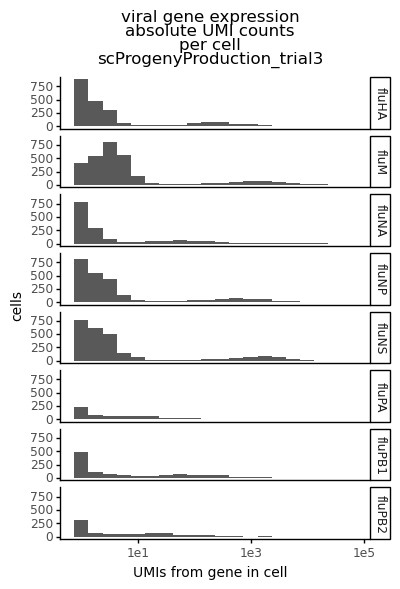

<ggplot: (8750263403319)>

In [14]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Distribution of viral gene expression in infected and **uninfected** cells:

**N.b.** Plot 0 values on far left of axis, 100-fold lower than lowest real value:

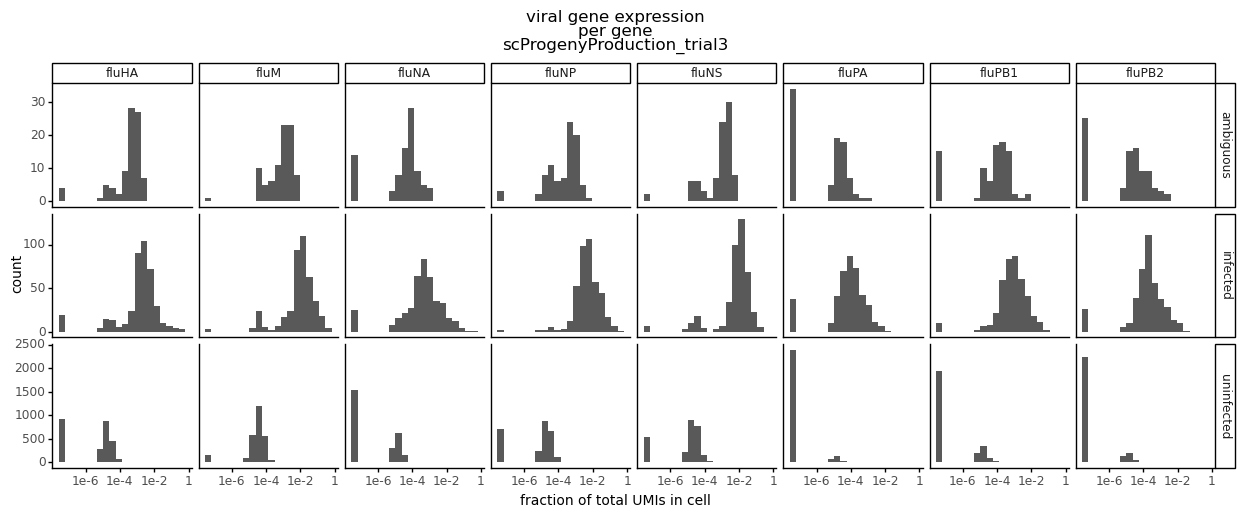

<ggplot: (8750262035029)>

In [15]:
zero_pseudocount = (min(viral_gene_expression_long
                        .query('frac_gene_UMIs > 0')
                        ['frac_gene_UMIs']) /
                    100)
zero_pseudocount

fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene', scales='free_y') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(15, 5),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Call presence/absence
Next I will extract a limit percentile value from the uninfected cells. We were very conservative in calling cells as infected (likely there are some infected cells in the population labelled "uninfected"). A priori, we expect most infected cells to express most viral genes. So we can be more lenient (lower percentile) in what we use as a cutoff in calling a gene present.

For low expressing genes (e.g. the polymerase complex), the limit value is 0, and this threshold does not work well. For these genes, instead, **we simply call genes without any UMIs as absent, and genes with at least 1 UMI as present.**  In some previous analyses (e.g. [Russel et al. 2018](https://elifesciences.org/articles/32303)) a single transcript was used to call the presence of a gene in infected cells.

Which genes are low expression?

In [16]:
viral_gene_expression_long.groupby('gene')['gene_UMIs'].mean()

gene
fluHA     128.384468
fluM      336.825184
fluNA      51.858421
fluNP     169.167466
fluNS     242.706616
fluPA       4.413231
fluPB1     40.348354
fluPB2     12.797379
Name: gene_UMIs, dtype: float64

In [17]:
low_expression_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluNA']
limit_percentile = 0.99
limit = dict()

for gene in viral_genes:
    if gene not in low_expression_genes:
        limit[gene] = (viral_gene_expression_long
                       .query('(infecting_viral_tag == "none") '
                              f'and (gene == "{gene}")')
                       ['frac_gene_UMIs']
                       .quantile(limit_percentile))

limit = pd.DataFrame.from_dict(limit, orient='index')
limit = limit.reset_index()
limit = limit.rename(columns={0: 'limit_frac',
                              'index': 'gene'})

display(limit)

,gene,limit_frac
0,fluHA,0.000095
1,fluNP,0.000120
2,fluM,0.000191
3,fluNS,0.000175


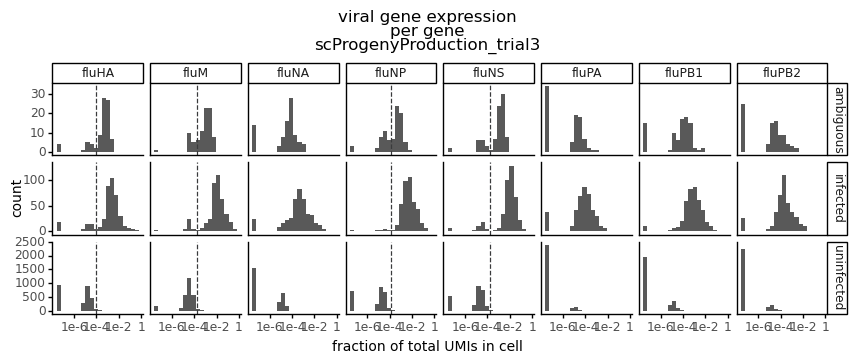

<ggplot: (8750263341008)>

In [18]:
fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.geom_vline(limit,
                     p9.aes(xintercept='limit_frac'),
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infected~gene', scales='free_y') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

Merge limit values into `viral_gene_expression_long` df.

In [19]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=limit,
    on='gene',
    how='left',
    validate='many_to_one'
)

display(viral_gene_expression_long)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,gene_UMIs,frac_gene_UMIs,limit_frac
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,fluPB2,0,0.000000,NaN
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,fluPB2,1,0.000011,NaN
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,fluPB2,0,0.000000,NaN
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,fluPB2,160,0.002816,NaN
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluPB2,3,0.000024,NaN
...,...,...,...,...,...,...,...,...,...,...
25027,TTTGATCTCAGTCATG,uninfected,none,44890,4,0.000089,fluNS,0,0.000000,0.000175
25028,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,fluNS,1,0.000016,0.000175
25029,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,fluNS,4,0.000061,0.000175
25030,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,fluNS,1230,0.008193,0.000175


Label genes as absent if they fall below this limit.

In [20]:
viral_gene_expression_long['gene_present'] = (
    (viral_gene_expression_long['gene_UMIs'] > 0)
    & ((viral_gene_expression_long['frac_gene_UMIs'] > 
        viral_gene_expression_long['limit_frac'])
       | (viral_gene_expression_long['limit_frac'].isnull())))

display(viral_gene_expression_long)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,gene_UMIs,frac_gene_UMIs,limit_frac,gene_present
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,fluPB2,0,0.000000,NaN,False
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,fluPB2,1,0.000011,NaN,True
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,fluPB2,0,0.000000,NaN,False
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,fluPB2,160,0.002816,NaN,True
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluPB2,3,0.000024,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
25027,TTTGATCTCAGTCATG,uninfected,none,44890,4,0.000089,fluNS,0,0.000000,0.000175,False
25028,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,fluNS,1,0.000016,0.000175,False
25029,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,fluNS,4,0.000061,0.000175,False
25030,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,fluNS,1230,0.008193,0.000175,True


### Visualize results

Color the proportion histogram by present/absent call:

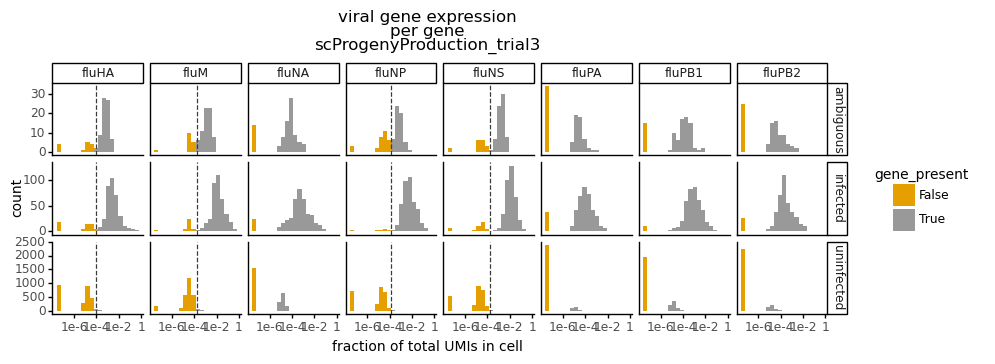

<ggplot: (8749601727073)>

In [21]:
fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs',
                        fill='gene_present')) +
       p9.geom_histogram(bins=20) +
       p9.geom_vline(limit,
                     p9.aes(xintercept='limit_frac'),
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infected~gene', scales='free_y') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10() +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]])
       )
display(fig)

In general, expression of all viral genes correlates with one another in infected cells.  Let's check to see if we are correctly excluding viral genes that violate this correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


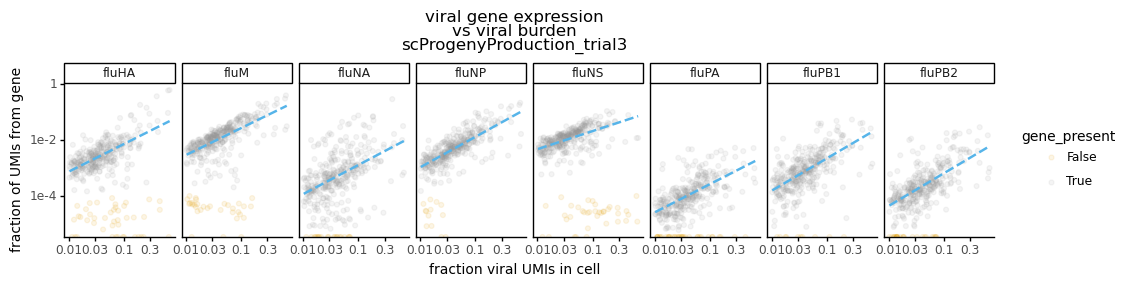

<ggplot: (8749602710312)>

In [22]:
gene_expression_plot = (
    p9.ggplot((viral_gene_expression_long
               .query('infected == "infected" and '
                      'infecting_viral_tag != "both"')),
               p9.aes(x='frac_viral_UMIs',
                      y='frac_gene_UMIs',
                      color='gene_present')) +
    p9.geom_point(alpha=0.1) +
    p9.geom_smooth((viral_gene_expression_long
                    .query('infected == "infected" and '
                           'infecting_viral_tag != "both" and '
                           'gene_present == True')),
                    p9.aes(x='frac_viral_UMIs',
                           y='frac_gene_UMIs'),
                    method='lm',
                    color=f'{CBPALETTE[2]}',
                    se=False,
                    linetype='dashed') +
    p9.facet_grid('~gene') +
    p9.ggtitle(f'viral gene expression\n'
               f'vs viral burden\n'
               f'{expt}') +
    p9.labs(x='fraction viral UMIs in cell',
            y='fraction of UMIs from gene') +
    p9.scale_x_log10() +
    p9.scale_y_log10() +
    p9.theme(figure_size=(12, 2),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=10),
             legend_title=p9.element_text(size=10),
             legend_title_align='center') +
    p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]))


display(gene_expression_plot)

Export gene expression plot:

In [23]:
print(f'Saving figure to {plot}"')
gene_expression_plot.save(plot)
print('Done.')

Saving figure to results/viral_fastq10x/scProgenyProduction_trial3_viral_genes_by_cell.svg"


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/viral_fastq10x/scProgenyProduction_trial3_viral_genes_by_cell.svg
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


Done.


Annotate the fraction of cells that have each viral gene:

In [24]:
has_gene = pd.DataFrame(
    viral_gene_expression_long
    .query('infecting_viral_tag != "both"')
    .groupby(['infected',
              'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='prop_cells'))

display(has_gene)

,infected,gene,gene_present,prop_cells
0,ambiguous,fluHA,True,0.823529
1,ambiguous,fluHA,False,0.176471
2,ambiguous,fluM,True,0.811765
3,ambiguous,fluM,False,0.188235
4,ambiguous,fluNA,True,0.835294
5,ambiguous,fluNA,False,0.164706
6,ambiguous,fluNP,True,0.647059
7,ambiguous,fluNP,False,0.352941
8,ambiguous,fluNS,True,0.800000
9,ambiguous,fluNS,False,0.200000


Plot this fraction for each gene and infecting viral tag:

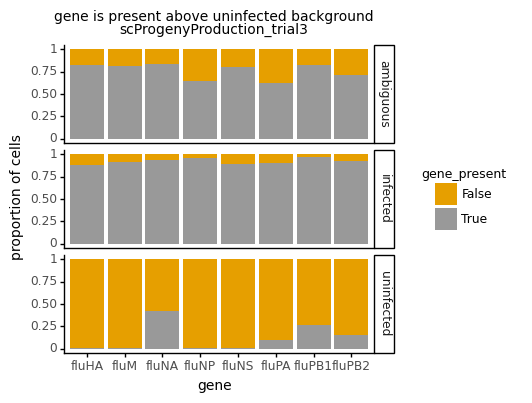

<ggplot: (8749602199926)>

In [25]:
fig = (p9.ggplot((has_gene),
                  p9.aes(x='gene',
                         y='prop_cells',
                         fill='gene_present')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('gene is present above uninfected background\n'
                         f'{expt}') +
              p9.ylab('proportion of cells') +
              p9.facet_grid('infected~') +
              p9.theme(figure_size=(4, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

In [26]:
has_gene_wt = pd.DataFrame(
    viral_gene_expression_long
    .query('infecting_viral_tag == "wt"')
    .groupby(['infected',
              'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='prop_cells'))

display(has_gene)

,infected,gene,gene_present,prop_cells
0,ambiguous,fluHA,True,0.823529
1,ambiguous,fluHA,False,0.176471
2,ambiguous,fluM,True,0.811765
3,ambiguous,fluM,False,0.188235
4,ambiguous,fluNA,True,0.835294
5,ambiguous,fluNA,False,0.164706
6,ambiguous,fluNP,True,0.647059
7,ambiguous,fluNP,False,0.352941
8,ambiguous,fluNS,True,0.800000
9,ambiguous,fluNS,False,0.200000


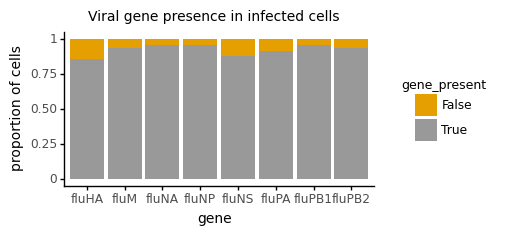

<ggplot: (8749602459109)>

In [27]:
fig = (p9.ggplot((has_gene_wt.query('infected == "infected"')),
                  p9.aes(x='gene',
                         y='prop_cells',
                         fill='gene_present')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('Viral gene presence in infected cells') +
              p9.labs(y='proportion of cells', legend="gene asdf") +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

### Count genes per cell
Count the number of viral genes called as present in each infected cell.

In [28]:
n_viral_genes_by_cell = (
    viral_gene_expression_long
    .query('gene_present == True')
    .groupby('cell_barcode')
    ['gene']
    .nunique()
    .reset_index()
    .drop_duplicates()
    .rename(columns={'gene': 'n_viral_genes'}))

viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=n_viral_genes_by_cell,
    on='cell_barcode',
    how='left'
)

viral_gene_expression_long['n_viral_genes'] = (
    viral_gene_expression_long['n_viral_genes'].fillna(0)
)
viral_gene_expression_long['n_viral_genes'] = (
    viral_gene_expression_long['n_viral_genes'].astype(int)
)

display(viral_gene_expression_long)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,gene,gene_UMIs,frac_gene_UMIs,limit_frac,gene_present,n_viral_genes
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,fluPB2,0,0.000000,NaN,False,0
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,fluPB2,1,0.000011,NaN,True,1
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,fluPB2,0,0.000000,NaN,False,0
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,fluPB2,160,0.002816,NaN,True,7
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,fluPB2,3,0.000024,NaN,True,8
...,...,...,...,...,...,...,...,...,...,...,...,...
25027,TTTGATCTCAGTCATG,uninfected,none,44890,4,0.000089,fluNS,0,0.000000,0.000175,False,0
25028,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,fluNS,1,0.000016,0.000175,False,0
25029,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,fluNS,4,0.000061,0.000175,False,1
25030,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,fluNS,1230,0.008193,0.000175,True,8


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


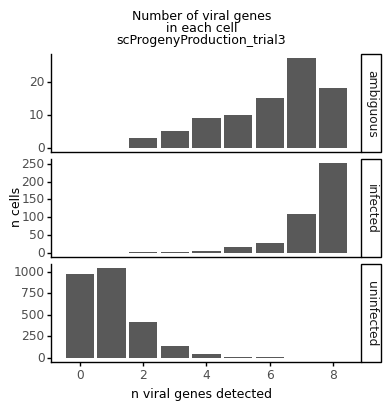

<ggplot: (8749602341861)>

In [29]:
n_viral_genes_histogram = (
    p9.ggplot((viral_gene_expression_long
               [['cell_barcode', 'infected', 'n_viral_genes']]
               .drop_duplicates()),
              p9.aes(x='n_viral_genes',)) +
    p9.geom_bar(stat='count', position='dodge') +
    p9.facet_grid('infected~', scales='free_y') + 
    p9.ggtitle('Number of viral genes\n'
               'in each cell\n'
               f'{expt}') +
    p9.labs(x='n viral genes detected',
            y='n cells') +
    p9.theme(figure_size=(4, 4),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_fill_manual(CBPALETTE[0:])
)

display(n_viral_genes_histogram)

Repeat just for WT infected cells

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


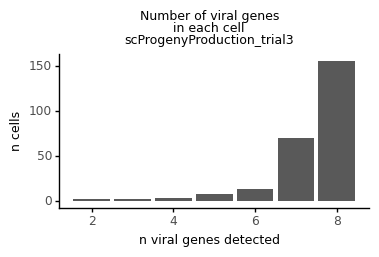

<ggplot: (8749602306214)>

In [34]:
n_viral_genes_histogram_wt = (
    p9.ggplot((viral_gene_expression_long
               .query('infecting_viral_tag == "wt" and infected == "infected"')
               [['cell_barcode', 'infected', 'n_viral_genes']]
               .drop_duplicates()),
              p9.aes(x='n_viral_genes',)) +
    p9.geom_bar(stat='count', position='dodge') +
    p9.ggtitle('Number of viral genes\n'
               'in each cell\n'
               f'{expt}') +
    p9.labs(x='n viral genes detected',
            y='n cells') +
    p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
    p9.scale_fill_manual(CBPALETTE[0:])
)

display(n_viral_genes_histogram_wt)

### Export annotations
Export a CSV with each cell barcode and whether each viral gene is called as present or absent for that cell.

In [31]:
gene_present_df = (
    viral_gene_expression_long[['cell_barcode',
                                'n_viral_genes',
                                'gene',
                                'gene_UMIs',
                                'frac_gene_UMIs',
                                'gene_present',]]
)
display(gene_present_df)
print(f'Writing gene presence data to {viral_genes_by_cell_csv}')
gene_present_df.to_csv(viral_genes_by_cell_csv, index=False)
print('Done.')

,cell_barcode,n_viral_genes,gene,gene_UMIs,frac_gene_UMIs,gene_present
0,AAACCCAGTAACAAGT,0,fluPB2,0,0.000000,False
1,AAACCCATCATTGCTT,1,fluPB2,1,0.000011,True
2,AAACGAAAGATGTTGA,0,fluPB2,0,0.000000,False
3,AAACGAAGTACTTCCC,7,fluPB2,160,0.002816,True
4,AAACGAAGTAGACGTG,8,fluPB2,3,0.000024,True
...,...,...,...,...,...,...
25027,TTTGATCTCAGTCATG,0,fluNS,0,0.000000,False
25028,TTTGATCTCCCGTTCA,0,fluNS,1,0.000016,False
25029,TTTGGAGAGTTGCCTA,1,fluNS,4,0.000061,False
25030,TTTGGAGGTATCGTTG,8,fluNS,1230,0.008193,True


Writing gene presence data to results/viral_fastq10x/scProgenyProduction_trial3_viral_genes_by_cell.csv.gz
Done.
